# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Eunice | Nwaobi | EN | 4h45m | 33.33% |
| Member 2: | Albert | Fudzi | AF | 4h45m | 33.33% |
| Member 3: | Ama | Yiadom Boakye | AYB | 4h45m | 33.33% |
| Member 4: | Ahsan | Farid | AF | Leave of Absense | Leave of Absense |


# **Non-linear Gradient Descent (25 marks)**

In [ ]:
%cd "/content/drive/MyDrive/ENGG680_LAB_ASSIGNMENTS"
!git config --global user.email "albert.fudzi@ucalgary.ca"
!git config --global user.name "Albert-Fudzi"
!git add .
!git commit -m "Finishing up"
!git push origin

/content/drive/MyDrive/ENGG680_LAB_ASSIGNMENTS
[main 39079c5] Tweaking gradient.
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Lab_Assignment3/Assignment3.ipynb (94%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 139.43 KiB | 4.81 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/eunice-nwaobi/ENGG680_LAB_ASSIGNMENTS.git
   bf8a317..39079c5  main -> main


### **Observations:** Pseudorange [m]

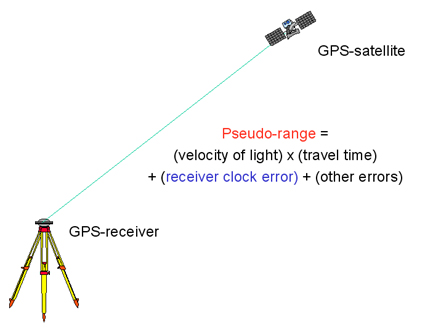

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [4]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/ENGG680_LAB_ASSIGNMENTS/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/ENGG680_LAB_ASSIGNMENTS/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

In [5]:
pseudorange

array([22919740.9614295, 20459894.0877988, 22400338.4134134,
       22829140.9126004, 22342014.8171753, 25646454.5362932,
       23814776.2454228, 24311399.3171521, 21353640.1406793,
       24971609.6374347, 20638981.0590005])

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [6]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [7]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [9]:
def euclidean_norm(receiver_pos, satellite_pos):
    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)
    return distance

### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [10]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
  L = np.mean((euclidean_norm(r_pos, s_pos)-cdT-pseudorange)**2)#
  return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [11]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
  rho = euclidean_norm(r_pos, s_pos)
  gradx = np.multiply(rho-cdT-pseudorange, np.divide(r_pos[0]-s_pos[:, 0], rho))
  grady = np.multiply(rho-cdT-pseudorange, np.divide(r_pos[1]-s_pos[:, 1], rho))
  gradz = np.multiply(rho-cdT-pseudorange, np.divide(r_pos[2]-s_pos[:, 2], rho))
  gradcdT = -rho+cdT+pseudorange
  grad = np.array([gradx, grady, gradz, gradcdT]).T
  grad = 2*np.mean(grad, axis=0)
  return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [12]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad


        #print(f"{iteration}: grad = {grad} cdT = {cdT} X = {X} Xnew = {X_new}")

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [13]:
optimized_params = gradient_descent(pseudorange, sat_pos)

# print the mentioned metrics
print()
print(f"optimized parameters {optimized_params}\n")
print(f"final position errors of receiver {arr_err[-1]}\n")
if steps_count == 0 and len(arr_err) > 0:
  print(f"number of steps taken for convergence {10000}\n")
else:
  print(f"number of steps taken for convergence {steps_count}\n")
print(f"final cost value {arr_cost[-1]}\n")
print(f"final gradient values {arr_grad[-1]}")

Converged !

optimized parameters [-1.63349244e+06 -3.65162953e+06  4.95248539e+06 -6.44838347e+00]

final position errors of receiver [-3.06240566 -2.34631388  3.77147769]

number of steps taken for convergence 2963

final cost value 0.5634455009259777

final gradient values [ 0.00015542  0.00086601 -0.00266161  0.00150894]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

In [14]:
steps_count, len(arr_cost)

(2963, 2963)

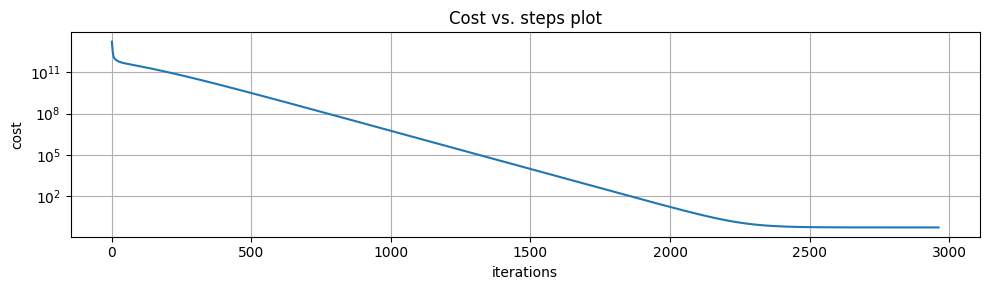

The graph shows a convergence of the cost between 2500-3000 iterations.


In [15]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.semilogy(list(range(steps_count)), arr_cost)
ax.grid(True)
plt.xlabel("iterations")
plt.ylabel("cost")
plt.title("Cost vs. steps plot")
fig.tight_layout()
plt.show()

# Comment on the pattern
print("The graph shows a convergence of the cost between 2500-3000 iterations.")

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

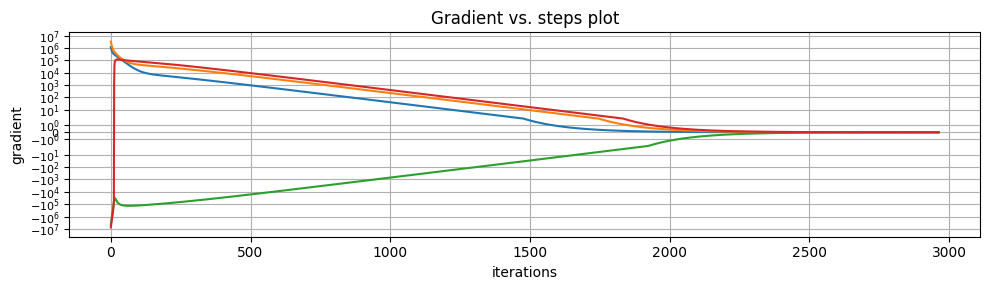

The gradient seems to converge to a point between 2200 to 2900.


In [16]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.plot(list(range(steps_count)), arr_grad)
ax.set_yscale("symlog")
ax.tick_params(axis="y", labelsize=8)
plt.xlabel("iterations")
plt.ylabel("gradient")
plt.title("Gradient vs. steps plot")
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("The gradient seems to converge to a point between 2200 to 2900.")

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

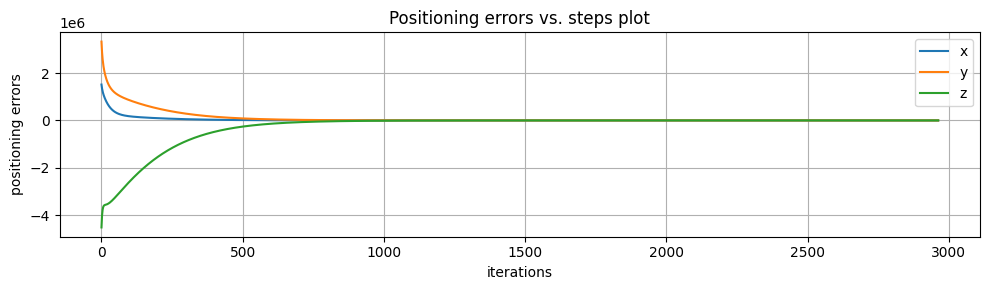

Again, the position errors converege to zero very quickly between 750 to 2900.


In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(list(range(steps_count)), arr_err)
plt.xlabel("iterations")
plt.ylabel("positioning errors")
plt.title("Positioning errors vs. steps plot")
plt.legend(["x", "y", "z"])
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("Again, the position errors converege to zero very quickly between 750 to 2900.")

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [18]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0
max_iters = 500000

optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=max_iters)

# print the metrics
print()
print(f"optimized parameters {optimized_params}\n")
print(f"final position errors of receiver {arr_err[-1]}\n")
if steps_count == 0 and len(arr_err) > 0:
  print(f"number of steps taken for convergence {max_iters}\n")
else:
  print(f"number of steps taken for convergence {steps_count}\n")
print(f"final cost value {arr_cost[-1]}\n")
print(f"final gradient values {arr_grad[-1]}")

Converged !

optimized parameters [-1.63349244e+06 -3.65162953e+06  4.95248539e+06 -6.44838347e+00]

final position errors of receiver [-3.05714443 -2.31699848  3.68137918]

number of steps taken for convergence 27900

final cost value 0.5641548583233607

final gradient values [ 0.00048857  0.00272232 -0.00836683  0.0047434 ]


In [19]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=0.001, max_iters=max_iters)

# print the metrics
print()
print(f"optimized parameters {optimized_params}\n")
print(f"final position errors of receiver {arr_err[-1]}\n")
if steps_count == 0 and len(arr_err) > 0:
  print(f"number of steps taken for convergence {max_iters}\n")
else:
  print(f"number of steps taken for convergence {steps_count}\n")
print(f"final cost value {arr_cost[-1]}\n")
print(f"final gradient values {arr_grad[-1]}")

Converged !

optimized parameters [-1.63349244e+06 -3.65162953e+06  4.95248539e+06 -6.44838347e+00]

final position errors of receiver [-3.04048553 -2.2241755   3.39609526]

number of steps taken for convergence 260921

final cost value 0.5712616917838825

final gradient values [ 0.00154538  0.00861082 -0.02646466  0.01500358]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)
  

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

Q1. Both lower learning rates (0.01 and 0.001) required more iterations before converging. However, the final cost values and the final gradient values increase with decreasing  learning rate.
The final position errors of the receiver are decreasing as the learning rate decreases.

Q2. With the gradient descent method we are using a matrix that is the gradient vector to descend into a global minimum. Whereas in the LSE we use a design matrix to minimize the difference between the predicted value then the correct value in essence minimizing the varience which is the square of that difference. Our results showed the convergence is slower because of the learning rate effect which makes it more the method more sensitive and accurate.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
data = phishing_websites.data
X = data.features
y = data.targets
X, y = X.to_numpy(), y.to_numpy()

# TO DO: display sizes of X and y (1 mark)
print(data)
print(X.shape, y.shape)
print(f"Sizes: X = {X.size}, y = {y.size}")

{'ids': None, 'features':        having_ip_address  url_length  shortining_service  having_at_symbol  \
0                     -1           1                   1                 1   
1                      1           1                   1                 1   
2                      1           0                   1                 1   
3                      1           0                   1                 1   
4                      1           0                  -1                 1   
...                  ...         ...                 ...               ...   
11050                  1          -1                   1                -1   
11051                 -1           1                   1                -1   
11052                  1          -1                   1                 1   
11053                 -1          -1                   1                 1   
11054                 -1          -1                   1                 1   

       double_slash_redirecting  pref

### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

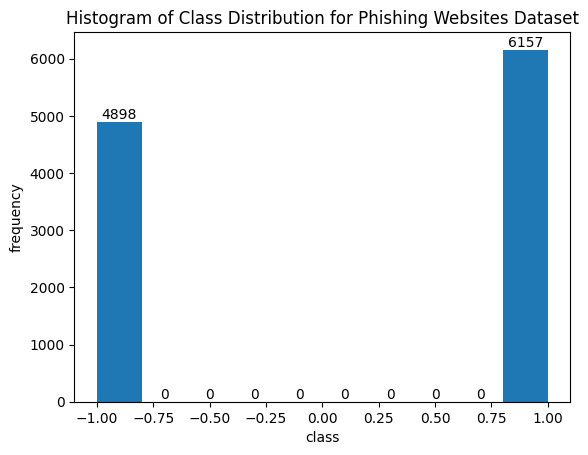

In [ ]:
# TO DO: Check the class distribution of y (2 mark)
counts, edges, bars = plt.hist(y)
plt.bar_label(bars)
plt.xlabel("class")
plt.ylabel("frequency")
plt.title("Histogram of Class Distribution for Phishing Websites Dataset")

# Display exact values for each bin in the histogram
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split
_, X_small, _, y_small = train_test_split(X, y, test_size=0.03, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
print(X_small.shape, y_small.shape)
print(f"Sizes: X = {X_small.size}, y = {y_small.size}")

(332, 30) (332, 1)
Sizes: X = 9960, y = 332


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

# STEP 3

from sklearn.linear_model import LogisticRegression

lr1 = LogisticRegression(max_iter=2000, random_state=0)
lr2 = LogisticRegression(max_iter=2000, random_state=0)
lr3 = LogisticRegression(max_iter=2000, random_state=0)

# implementation 1
lr1.fit(X, y.reshape(-1,))

# implementation 2
lr2.fit(X[:, :2], y.reshape(-1,))

# implementation 3
lr3.fit(X_small, y_small.reshape(-1,))


# STEP 4
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# data size
print(f"Data size for first implementation X: {X.size}, y: {y.reshape(-1,).size}.")
print(f"Data size for second implementation X: {X[:, :2].size}, y: {y.reshape(-1,).size}.")
print(f"Data size for third implementation X: {X_small.size}, y: {y_small.reshape(-1,).size}.")

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_cond_train, X_cond_test, y_cond_train, y_cond_test = train_test_split(X[:, :2], y, test_size=0.3, random_state=0)
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(X_small, y_small, test_size=0.3, random_state=0)

y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)
y_cond_train = y_cond_train.reshape(-1,)
y_cond_test = y_cond_test.reshape(-1,)
y_small_train = y_small_train.reshape(-1,)
y_small_test = y_small_test.reshape(-1,)

# print number of training samples
print(f"Number of training samples for first implementation is: {X_train.shape[0]}.")
print(f"Number of training samples for second implementation is: {X_cond_train.shape[0]}.")
print(f"Number of training samples for third implementation is: {X_small_train.shape[0]}.")

# print number of testing samples
print(f"Number of testing samples for first implementation is: {X_test.shape[0]}.")
print(f"Number of testing samples for second implementation is: {X_cond_test.shape[0]}.")
print(f"Number of testing samples for third implementation is: {X_small_test.shape[0]}.")

# training accuracy
lr1.fit(X_train, y_train)
ytr1 = lr1.predict(X_train)
trainAcc1 = accuracy_score(y_train, ytr1)
lr2.fit(X_cond_train, y_cond_train)
ytr2 = lr2.predict(X_cond_train)
trainAcc2 = accuracy_score(y_cond_train, ytr2)
lr3.fit(X_small_train, y_small_train)
ytr3 = lr3.predict(X_small_train)
trainAcc3 = accuracy_score(y_small_train, ytr3)
print(f"Training accuracy for first implementation is: {trainAcc1}.")
print(f"Training accuracy for second implementation is: {trainAcc2}.")
print(f"Training accuracy for third implementation is: {trainAcc3}.")

# testing accuracy
yt1=lr1.predict(X_test)
testAcc1 = accuracy_score(y_test, yt1)
yt2=lr2.predict(X_cond_test)
testAcc2 = accuracy_score(y_cond_test, yt2)
yt3=lr3.predict(X_small_test)
testAcc3 = accuracy_score(y_small_test, yt3)
print(f"Testing accuracy for first implementation is: {testAcc1}.")
print(f"Testing accuracy for second implementation is: {testAcc2}.")
print(f"Testing accuracy for third implementation is: {testAcc3}.")

# log loss
ll1 = log_loss(y_test, yt1)
ll2 = log_loss(y_cond_test, yt2)
ll3 = log_loss(y_small_test, yt3)
print(f"Log loss for first implementation is: {ll1}.")
print(f"Log loss for second implementation is: {ll2}.")
print(f"Log loss for third implementation is: {ll3}.")


# STEP 5.1
colnames = ["Data Size", "Training Samples", "Testing Samples", "Training Accuracy", "Testing Accuracy", "Log Loss"]
indexnames=["Impl1", "Impl2", "Impl3"]
i1 = [X.size, X_train.shape[0], X_test.shape[0], trainAcc1, testAcc1, ll1]
i2 = [X[:, :2].size, X_cond_train.shape[0], X_cond_test.shape[0], trainAcc2, testAcc2, ll2]
i3 = [X_small.size, X_small_train.shape[0], X_small_test.shape[0], trainAcc3, testAcc3, ll3]
datamatrix = np.array([i1, i2, i3])
results = pd.DataFrame(datamatrix, index=indexnames, columns=colnames)
print(f"\nOur results:\n{results}")

Data size for first implementation X: 331650, y: 11055.
Data size for second implementation X: 22110, y: 11055.
Data size for third implementation X: 9960, y: 332.
Number of training samples for first implementation is: 7738.
Number of training samples for second implementation is: 7738.
Number of training samples for third implementation is: 232.
Number of testing samples for first implementation is: 3317.
Number of testing samples for second implementation is: 3317.
Number of testing samples for third implementation is: 100.
Training accuracy for first implementation is: 0.9322822434737659.
Training accuracy for second implementation is: 0.5628069268544844.
Training accuracy for third implementation is: 0.9741379310344828.
Testing accuracy for first implementation is: 0.9228218269520652.
Testing accuracy for second implementation is: 0.5568284594513114.
Testing accuracy for third implementation is: 0.89.
Log loss for first implementation is: 2.7817833185450684.
Log loss for second im

### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

print(f"Dimension of predicted output: {yt1.shape}.")

Dimension of predicted output: (3317,).


Confusion matrix: [[1341  157]
 [  99 1720]].


Text(113.9222222222222, 0.5, 'true value')

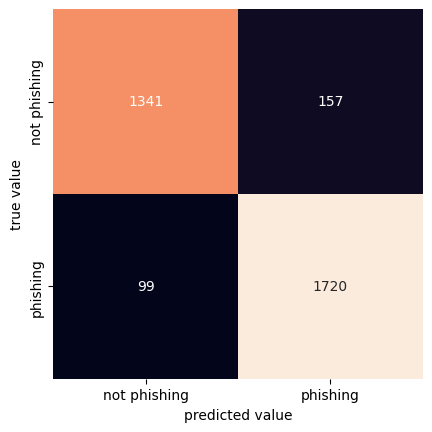

In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
from sklearn.metrics import confusion_matrix, classification_report

conf_mat = confusion_matrix(y_test, yt1)
print(f"Confusion matrix: {conf_mat}.")

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# TO DO: Print classification report (2 marks)

cr = classification_report(y_test, yt1)
print(f"Confusion matrix: {cr}.")

Confusion matrix:               precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317
.


### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---

In [ ]:
print(f"Question 1) Given a -1 support of {np.round(1498*100/3317, decimals=2)}% and 1 support of {np.round(1819*100/3317, decimals=2)}%,\n the data is nearly balanced. However, the 1 predictions\nhave an overall higher performance than class -1. This is likely the cause.")

Question 1) Given a -1 support of 45.16% and 1 support of 54.84%,
 the data is nearly balanced. However, the 1 predictions
have an overall higher performance than class -1. This is likely the cause.


In [ ]:
print(f"Question 2) For the first and second implementations, the difference between the testing and training accuracies are not significant.\nTherefore, the models are not overfit. However, the last model reports an accuracy of .97 in its training set\nand .89 in its test set which leads us to believe it is overfit.\n Additionally, the low performance of the second model on both training and testing set is a suggestion\nthat the model is underfit for the real-world scenario.")

Question 2) For the first and second implementations, the difference between the testing and training accuracies are not significant.
Therefore, the models are not overfit. However, the last model reports an accuracy of .97 in its training set
and .89 in its test set which leads us to believe it is overfit.
 Additionally, the low performance of the second model on both training and testing set is a suggestion
that the model is underfit for the real-world scenario.


In [ ]:
print(f"Question 3) The first implementation uses a full dataset with all the features and samples\n has a training accuracy of {results.loc['Impl1', 'Training Accuracy']} and testing accuracy of {results.loc['Impl1', 'Testing Accuracy']}.\nWhen compared with a set that retains the same number of samples but reduces the number of features,\nwe see a significant underperformance in training {results.loc['Impl2', 'Training Accuracy']} and testing {results.loc['Impl2', 'Testing Accuracy']},\nindicating the feature space is not sufficient to capture the complexity of the dataset.\nThe final model suggest that even though the dataset has enough features but less examples,\nit performs better than the second implementation. The drawback of not having enough data\nis that the model overfits to the sample space. This is seen with the training accuracy of {results.loc['Impl3', 'Training Accuracy']}\nand testing accuracy of {results.loc['Impl3', 'Testing Accuracy']}.")

Question 3) The first implementation uses a full dataset with all the features and samples
 has a training accuracy of 0.9322822434737659 and testing accuracy of 0.9228218269520652.
When compared with a set that retains the same number of samples but reduces the number of features,
we see a significant underperformance in training 0.5628069268544844 and testing 0.5568284594513114,
indicating the feature space is not sufficient to capture the complexity of the dataset.
The final model suggest that even though the dataset has enough features but less examples,
it performs better than the second implementation. The drawback of not having enough data
is that the model overfits to the sample space. This is seen with the training accuracy of 0.9741379310344828
and testing accuracy of 0.89.


In [ ]:
print(f"Question 4) False positives occur when a non-phishing website is predicted as phishing.\nFalse negatives occur when inappropriate websites are predicted as normal.\nIt's challenging to say because a malicious website might introduce malware to your computer if undetected.\nNotwithstanding, a FP could occur for a workplace server or website and this could be equally annoying.\nFor this problem, it may be more severe to have a FN because of high risk of malware.\nEither scenario would require troubleshooting.")

Question 4) False positives occur when a non-phishing website is predicted as phishing.
False negatives occur when inappropriate websites are predicted as normal.
It's challenging to say because a malicious website might introduce malware to your computer if undetected.
Notwithstanding, a FP could occur for a workplace server or website and this could be equally annoying.
For this problem, it may be more severe to have a FN because of high risk of malware.
Either scenario would require troubleshooting.


In [ ]:
print("Question 5) We think it is more dangerous to pass a phishing website as a genuine one than to pass a\nnon-phishing website as phishing. So, we believe maximizing the recall would in turn minimize our FNs\nbased on the formula: TP/(TP+FN).")

Question 5) We think it is more dangerous to pass a phishing website as a genuine one than to pass a
non-phishing website as phishing. So, we believe maximizing the recall would in turn minimize our FNs
based on the formula: TP/(TP+FN).


In [ ]:
print("Question 6) The log loss is an indication of how well the model performs and how likely it is to be\noverfit or underfit for predictions. The higher the loss, the worse the model performance.\nThis also increases the likelihood of underfitting and overfitting.")

Question 6) The log loss is an indication of how well the model performs and how likely it is to be
overfit or underfit for predictions. The higher the loss, the worse the model performance.
This also increases the likelihood of underfitting and overfitting.
